# Predicting the Condition of Water Wells in Tanzania


## Business Understanding
## Problem Description

Tanzania, with a population of over 57 million, faces significant challenges in providing access to clean and reliable water sources. While numerous water points (wells, boreholes, and pumps) have been established across the country, many are non-functional, in need of repair, or have failed altogether. This situation exacerbates water scarcity, particularly in rural and underserved areas, impacting public health, economic productivity, and overall quality of life.

The Government of Tanzania, in collaboration with NGOs and development partners, is committed to improving water infrastructure. However, limited resources and the vast number of water points make it difficult to prioritize repairs and maintenance. A data-driven approach to predict the condition of water wells can help the government and NGOs identify non-functional or at-risk wells, allocate resources efficiently, and inform future water infrastructure planning.

### OBJECTIVES
The research seeks to meet the following objectives:

 1. Analyze the Impact of Age, Technology, and Investment on Water Point Failure
 2. Assess the Impact of Socioeconomic and Geographical Factors
 3. Develop a Predictive Model for Water Point Failure

### Data Understanding
This research utilized data from [DrivenData](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/) about waterpoints. The dataset was split into three CSV files:

 1. Training set values
 2. Training set labels
 3. Test set values
 
The training and test datasets contained similar columns, while the training set labels dataset included one column, which was the focus of the study.

#### Load Packages and Data

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [7]:
# Load the predictor data

wells = pd.read_csv('Data\Training set values.csv')
wells.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [8]:
# Load the target data

target = pd.read_csv('Data\Training set labels.csv')

target.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


## 1. Exploratory Data Analysis

Get a sense of the big picture for the dataset. Prepare the data for further analysis. Gain an understanding of the variables, or predictors in this case. Study the relationship between variables. Make plan for initial model. 

In [9]:
# Identify size of dataset

print("Records for wells:", wells.shape)
print()
print("Records for target:", target.shape)

Records for wells: (59400, 40)

Records for target: (59400, 2)


In [10]:
# Identify datatypes and record amount for each predictor

wells.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [11]:
# Examine numerical predictors mean, min, max

wells.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [12]:
# Missing data total
wells.isna().sum().sum()

46094

In [13]:
# Missing data by predictor

wells.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [14]:
# Data missing for target
target.isna().sum()

id              0
status_group    0
dtype: int64

In [15]:
# Examine value counts for the target, consider imbalance in target data
target['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [16]:
# Percentage makeup of target values
print("Functional percentage:", round(32259/59400*100, 2))
print("Non functional percentage:", round(22824/59400*100, 2))
print("Functional needs repair percentage:", round(4317/59400*100, 2))

Functional percentage: 54.31
Non functional percentage: 38.42
Functional needs repair percentage: 7.27


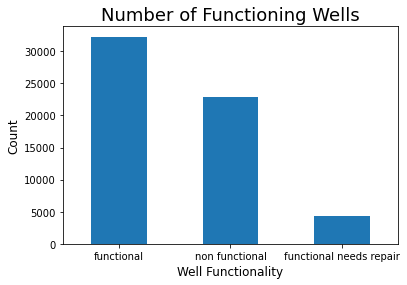

<Figure size 432x288 with 0 Axes>

In [17]:
# Visually plot target variable counts

target.status_group.value_counts().plot(kind="bar")
plt.title("Number of Functioning Wells",fontsize= 18)
plt.xlabel("Well Functionality", fontsize = 12)
plt.xticks(rotation=0)
plt.ylabel("Count", fontsize = 12)
plt.show();

plt.savefig('Number of Functioning Wells')

In [18]:
# Identify unique values per column
print(wells.nunique())

id                       59400
amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_

In [19]:
# Concatenate preds and target for heatmap 

df = pd.concat([wells, target], axis =1)

df = df.loc[:,~df.columns.duplicated()].copy()

df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


#### Correlation of numeric data

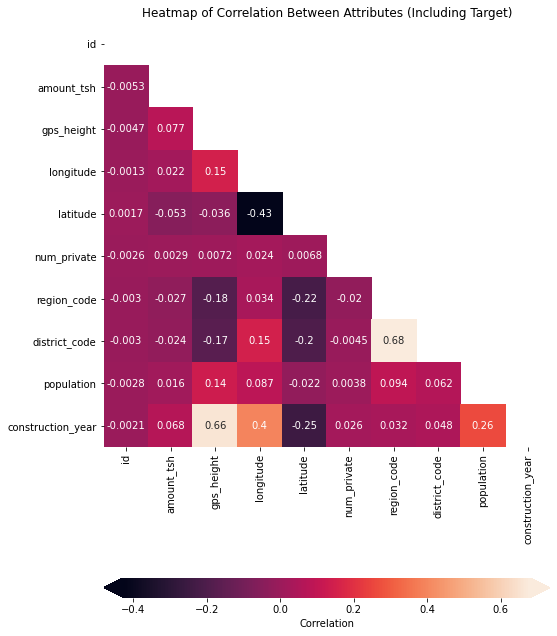

In [20]:
# Create a heatmap to examine the correlational coefficents


corr = df.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(8, 12))

# Plot a heatmap of the correlations

sns.heatmap(
    
    data=corr,
    
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    
    ax=ax,
    
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

AxesSubplot(0.125,0.125;0.775x0.755)


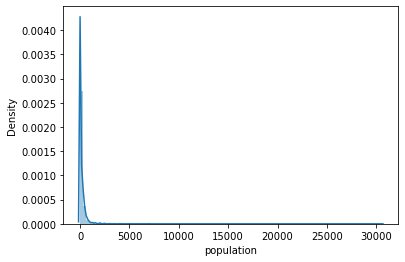

In [21]:
# Check distribution for numeric data
import warnings
warnings.filterwarnings('ignore')

print(sns.distplot(wells.population, bins = 100))



<AxesSubplot:xlabel='population'>

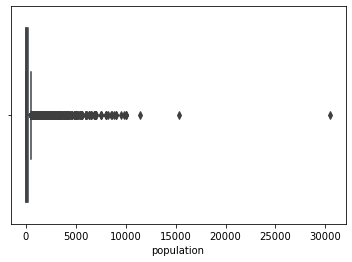

In [22]:
# Identify range of population and any outliers

sns.boxplot(wells.population)


In [23]:
# Identify population counts
print(wells.population.value_counts())
print(wells.population.nunique())

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64
1049


#### Total Static Head data

count     59400.000000
mean        317.650385
std        2997.574558
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      350000.000000
Name: amount_tsh, dtype: float64


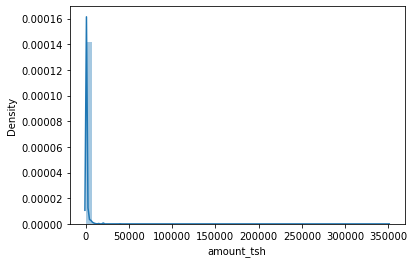

In [24]:
# Plot and descrive total static head

sns.distplot(wells.amount_tsh)

print(wells.amount_tsh.describe())


<AxesSubplot:xlabel='amount_tsh'>

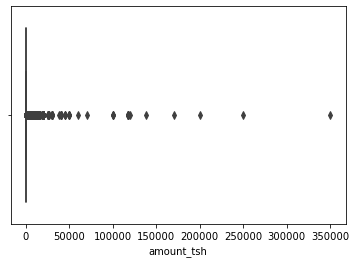

In [25]:
# Identify range and outliers of total static head

sns.boxplot(wells.amount_tsh)

In [26]:
# Identify how many wells do not have static head

print(wells.amount_tsh.value_counts())

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64


#### Geographic Data

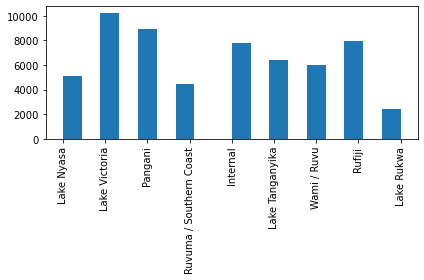

In [27]:
# plot basins
fig, axs = plt.subplots(1, 1,
                        figsize =(6, 4),
                        tight_layout = True)
 
axs.hist(wells.basin, bins = 18)
plt.xticks(rotation = 90)

plt.show()

In [28]:
# How many wells are in each basin

wells.basin.value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

In [29]:

wells.region.value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [30]:
wells.district_code.value_counts()

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

In [31]:
wells.region_code.value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

#### Water attributes

In [32]:
wells.water_quality.value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [33]:
wells.quality_group.value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

In [34]:
wells.quantity.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [35]:
wells.quantity_group.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

In [36]:
wells.scheme_name.value_counts()

K                       682
None                    644
Borehole                546
Chalinze wate           405
M                       400
                       ... 
Forforo water supply      1
KKKT Water Project        1
Shahude water supply      1
Usambara Mountai          1
Kima                      1
Name: scheme_name, Length: 2696, dtype: int64

In [37]:
wells.scheme_management.value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [38]:
wells.extraction_type.value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [39]:
wells.extraction_type_group.value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [40]:
wells.extraction_type_class.value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [41]:
wells.source.value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [42]:
wells.source_type.value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [43]:
wells.waterpoint_type_group.value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [44]:
wells.source_class.value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

In [45]:
wells.waterpoint_type.value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

#### Organizational attributes

In [46]:
wells.funder.value_counts()

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Hhesawa                      1
Tcrs Kibondo                 1
Dmk Anglican                 1
Luali Kaima                  1
Rotary                       1
Name: funder, Length: 1897, dtype: int64

In [47]:
wells.num_private.value_counts()

0      58643
6         81
1         73
5         46
8         46
       ...  
180        1
213        1
23         1
55         1
94         1
Name: num_private, Length: 65, dtype: int64

In [48]:
wells.permit.value_counts()

True     38852
False    17492
Name: permit, dtype: int64

In [49]:
wells.management.value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [50]:
wells.management_group.value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

In [51]:
wells.payment.value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [52]:
wells.payment_type.value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [53]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(wells[1000:1020])

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
1000,47384,250.0,2013-02-14,Oxfam,1409,OXFAM,30.105401,-4.367134,Ofisi Ya Kijiji,0,Lake Tanganyika,Kamana,Kigoma,16,2,Kasulu,Munyegera,620,True,GeoData Consultants Ltd,Water authority,Mtobo,True,1996,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
1001,11570,0.0,2012-10-12,Resolute Mining,0,Consulting Engineer,33.210098,-4.049685,Igabanilo,0,Internal,Mwatandai,Tabora,14,1,Nzega,Lusu,0,False,GeoData Consultants Ltd,VWC,NaN,False,0,afridev,afridev,handpump,vwc,user-group,never pay,never pay,salty,salty,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,41433,0.0,2011-03-05,Government Of Tanzania,1307,DWE,38.325050,-4.464609,Kwa Mzee Noa,0,Pangani,Lugwashi,Tanga,4,1,Lushoto,Mbaramo,1,True,GeoData Consultants Ltd,VWC,Shagai streem,True,1985,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1019,21810,0.0,2013-01-17,Bulyahunlu Gold Mine,0,Bulyahunlu Gold Mine,32.370100,-3.281536,Ibanza,0,Lake Tanganyika,Ibanza,Shinyanga,17,3,Kahama,Bugarama,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,other,other,other,vwc,user-group,unknown,unknown,milky,milky,enough,enough,shallow well,shallow well,groundwater,other,other


## 2. Preprocess data, Initial Model

Redundant data columns where the data is included in other columns that contain more expansive information should be dropped: water attributes, geographic attributes,  include water include regional columns, water extraction and source types.

Drop columns that do not contribute to the model. These include water id, names of the waterpoint, names of subvillages.  

Make plan for missing categorical and numeric data.

In [54]:
# Drop redundant data columns and columns that do not contribute to model, i.e. names.
wells.drop(columns = ['id', 'wpt_name', 'region', 'recorded_by', 'scheme_name', 
           'scheme_management', 'extraction_type_group', 'payment_type', 'subvillage',
           'quality_group', 'quantity_group', 'source_type', 'waterpoint_type'], inplace = True)


In [55]:
wells.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'num_private', 'basin', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'water_quality', 'quantity', 'source', 'source_class',
       'waterpoint_type_group'],
      dtype='object')

In [56]:
# Check missing data
wells.isna().sum()

amount_tsh                  0
date_recorded               0
funder                   3635
gps_height                  0
installer                3655
longitude                   0
latitude                    0
num_private                 0
basin                       0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting           3334
permit                   3056
construction_year           0
extraction_type             0
extraction_type_class       0
management                  0
management_group            0
payment                     0
water_quality               0
quantity                    0
source                      0
source_class                0
waterpoint_type_group       0
dtype: int64

In [57]:
# Replace Nan in public_meeting and permit as False

wells['public_meeting'] = wells['public_meeting'].fillna('False').astype('bool')
wells.public_meeting.head()

0    True
1    True
2    True
3    True
4    True
Name: public_meeting, dtype: bool

In [58]:
# replace missing permit data as False
wells['permit'] = wells['permit'].fillna('False').astype('bool')
wells.permit.head()

0    False
1     True
2     True
3     True
4     True
Name: permit, dtype: bool

In [59]:
# Convert "date_recorded" to month_recorded

import datetime 

wells['date_recorded'] = pd.to_datetime(wells['date_recorded'])
wells['month_recorded'] = wells['date_recorded'].dt.month
wells['month_recorded']

0        3
1        3
2        2
3        1
4        7
        ..
59395    5
59396    5
59397    4
59398    3
59399    3
Name: month_recorded, Length: 59400, dtype: int64

In [60]:
wells.drop('date_recorded', axis = 1, inplace = True)

#### Initial Model - Logistic Regression 

Use a Logistic Regression model in a pipeline for initial model results.

In [61]:
# Assign the predictors and target
X = wells
y = target['status_group']

In [62]:
# Perform a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [63]:
X_train.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'num_private', 'basin', 'region_code', 'district_code',
       'lga', 'ward', 'population', 'public_meeting', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_class',
       'management', 'management_group', 'payment', 'water_quality',
       'quantity', 'source', 'source_class', 'waterpoint_type_group',
       'month_recorded'],
      dtype='object')

In [64]:
# Examine data types and record counts
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44550 entries, 24947 to 56422
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             44550 non-null  float64
 1   funder                 41859 non-null  object 
 2   gps_height             44550 non-null  int64  
 3   installer              41850 non-null  object 
 4   longitude              44550 non-null  float64
 5   latitude               44550 non-null  float64
 6   num_private            44550 non-null  int64  
 7   basin                  44550 non-null  object 
 8   region_code            44550 non-null  int64  
 9   district_code          44550 non-null  int64  
 10  lga                    44550 non-null  object 
 11  ward                   44550 non-null  object 
 12  population             44550 non-null  int64  
 13  public_meeting         44550 non-null  bool   
 14  permit                 44550 non-null  bool   
 15

In [65]:


# create subpipe for numeric data

subpipe_num = Pipeline(steps=[('num_impute', SimpleImputer()),
                           ('ss', StandardScaler())])

# create subpipe for categorical data, use SimpleImputer for 'missing' data.

subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='constant', fill_value = 'missing')),
                             ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

# combine subpipes into ColumnTransformer

CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, [0, 2, 4, 5, 12]),
                                    ('subpipe_cat', subpipe_cat, [1, 3, 6, 7, 8, 9, 10, 
                                                                  11, 13, 14, 15, 16,
                                                                  17, 18, 19, 20, 21, 
                                                                  22, 23, 24, 25, 26])],
                           remainder='passthrough')



In [66]:
#Perform Logistic Regression for initial model

log_reg_pipe = Pipeline(steps = [('ct', CT), 
                           ('log_reg', LogisticRegression(random_state = 42))])

In [67]:
# Fit the logistic regression model
log_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 2, 4, 5, 12]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                             

#### Evaluate initial model

In [68]:
# Score the log reg model
log_reg_pipe.score(X_train, y_train)

0.8025813692480359

In [69]:
# create predicted target variable
y_hat = log_reg_pipe.predict(X_test)

In [70]:
# Generate log_reg classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_hat))

                         precision    recall  f1-score   support

             functional       0.78      0.88      0.83      8098
functional needs repair       0.55      0.25      0.34      1074
         non functional       0.80      0.74      0.77      5678

               accuracy                           0.78     14850
              macro avg       0.71      0.62      0.65     14850
           weighted avg       0.77      0.78      0.77     14850



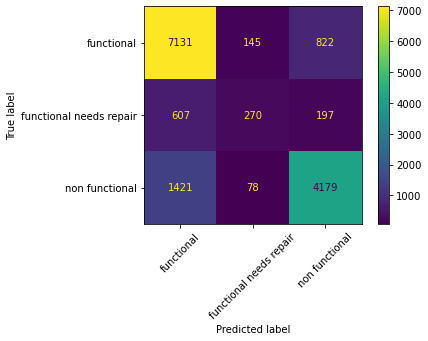

In [71]:
plot_confusion_matrix(log_reg_pipe, X_test, y_test, xticks_rotation=45);

In [72]:
# Save model in Joblib
from joblib import Parallel, delayed
import joblib

import pickle
  
# Save the model as a pickle in a file
joblib.dump(log_reg_pipe, 'log_reg.pkl')
  
# Load the model from the file
#log_reg_from_joblib = joblib.load('log_reg.pkl')
  
# Use the loaded model to make predictions
#log_reg_from_joblib.predict(X_test)

['log_reg.pkl']

## 3. Decision Tree Model with Parameter Tuning

Considering the dataset a decision tree would be a useful secondary model. Use hyperparameter tuning to improve upon the initial logistic regression model.

In [73]:
import category_encoders as ce


# create subpipe for numeric data

subpipe_num = Pipeline(steps=[('num_impute', SimpleImputer()),
                           ('ss', StandardScaler())])

# create subpipe for categorical data, use SimpleImputer for 'missing' data.

subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='constant', fill_value = 'missing')),
                             ('ce_loo', ce.OrdinalEncoder(return_df = True))])

# combine subpipes into ColumnTransformer

CT_loo = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, [0, 2, 4, 5, 12]),
                                    ('subpipe_cat', subpipe_cat, [1, 3, 6, 7, 8, 9, 10, 
                                                                  11, 13, 14, 15, 16,
                                                                  17, 18, 19, 20, 21, 
                                                                  22, 23, 24, 25, 26])],
                           remainder='passthrough', n_jobs = -1)


ModuleNotFoundError: No module named 'category_encoders'

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit_transform(y_train)

array([2, 0, 0, ..., 2, 0, 2])

In [ ]:
cols = ['funder', 'installer', 'num_private', 'basin', 
       'region_code', 'district_code', 'lga', 'ward', 
       'construction_year', 'extraction_type', 'extraction_type_class', 
       'management', 'management_group', 'payment', 'water_quality', 
       'quantity', 'source', 'source_class', 'waterpoint_type_group', 
       'month_recorded']

X_train[cols] = X_train[cols].astype(str)
X_test[cols] = X_test[cols].astype(str)

In [ ]:
# Use a decision tree for the secondary model
dtc = DecisionTreeClassifier(random_state = 42)    

dtc_pipe = Pipeline(steps=[('ct_loo', CT_loo), 
                           ('dtc', dtc)])

In [ ]:
dtc_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct_loo',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 2, 4, 5, 12]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ce_loo',
           

In [ ]:
dtc_pipe.score(X_train, y_train)

0.9984960718294051

#### Evaluate Decision Tree Model

In [ ]:
y_hat = dtc_pipe.predict(X_test)

In [ ]:
print(classification_report(y_test, y_hat))

                         precision    recall  f1-score   support

             functional       0.80      0.80      0.80      8098
functional needs repair       0.36      0.36      0.36      1074
         non functional       0.77      0.76      0.77      5678

               accuracy                           0.76     14850
              macro avg       0.64      0.64      0.64     14850
           weighted avg       0.76      0.76      0.76     14850



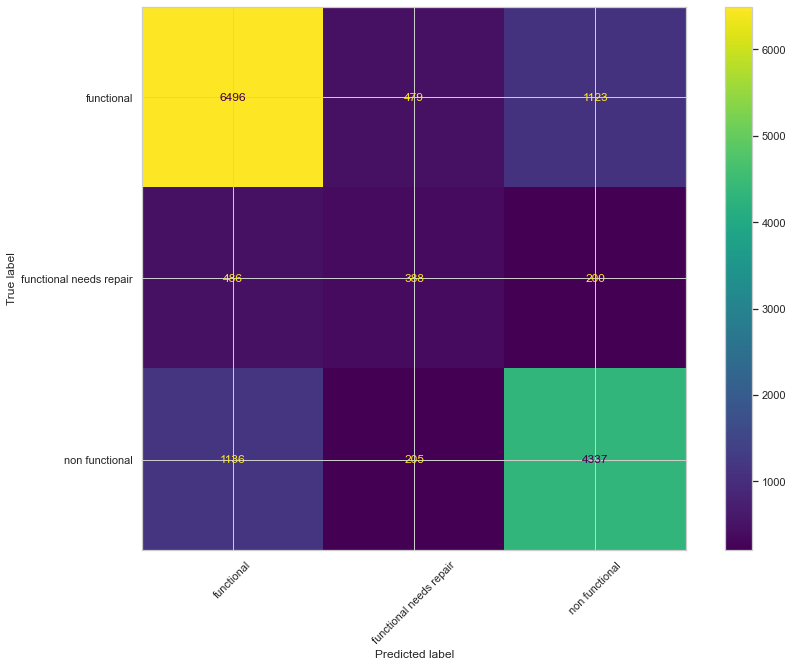

In [ ]:
plot_confusion_matrix(dtc_pipe, X_test, y_test, xticks_rotation=45);

In [ ]:
len(dtc_pipe.named_steps['dtc'].feature_importances_)

27

In [ ]:
model_tree = dtc_pipe.named_steps['dtc']
model_tree.feature_importances_

array([0.02420042, 0.06744788, 0.15358044, 0.14229542, 0.04049446,
       0.04084094, 0.02766165, 0.0013189 , 0.00897386, 0.01082605,
       0.01215422, 0.02326186, 0.04666773, 0.00409639, 0.00569057,
       0.0350141 , 0.02393515, 0.01301596, 0.01250364, 0.00512469,
       0.02150802, 0.00995001, 0.15799101, 0.02366923, 0.00320772,
       0.06980831, 0.01476137])

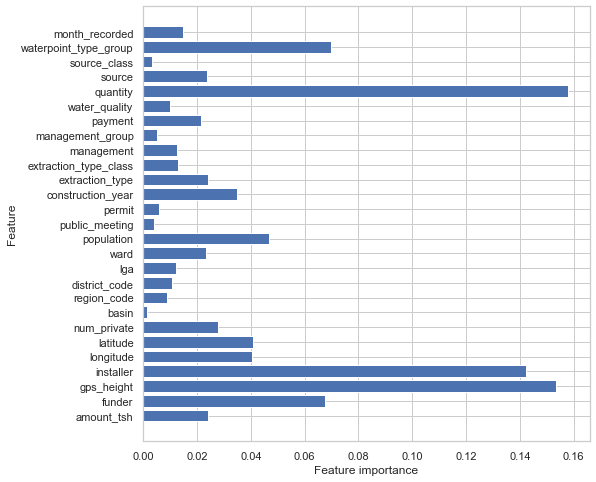

In [ ]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(model_tree)

In [ ]:
# Conduct inverse_transform of one hot encoding

In [ ]:
important_features_dict = {}
for idx, val in enumerate(model_tree.feature_importances_):
    important_features_dict[idx] = val

important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print(f'5 most important features: {important_features_list[:10]}')

5 most important features: [5941, 2, 3, 5958, 1, 4, 0, 5, 5939, 5938]


<AxesSubplot:>

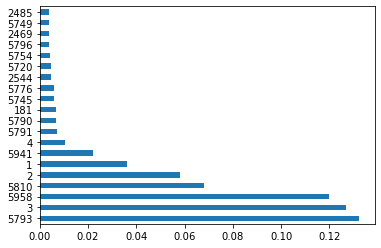

In [ ]:
feat_importances = pd.Series(model_tree.feature_importances_, index= important_features_list)
feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
X_train.nunique()

amount_tsh                  95
funder                    1645
gps_height                2391
installer                 1861
longitude                43171
latitude                 43173
num_private                 59
basin                        9
region_code                 27
district_code               20
lga                        125
ward                      2071
population                 951
public_meeting               2
permit                       2
construction_year           55
extraction_type             18
extraction_type_class        7
management                  12
management_group             5
payment                      7
water_quality                8
quantity                     5
source                      10
source_class                 3
waterpoint_type_group        6
month_recorded              12
dtype: int64

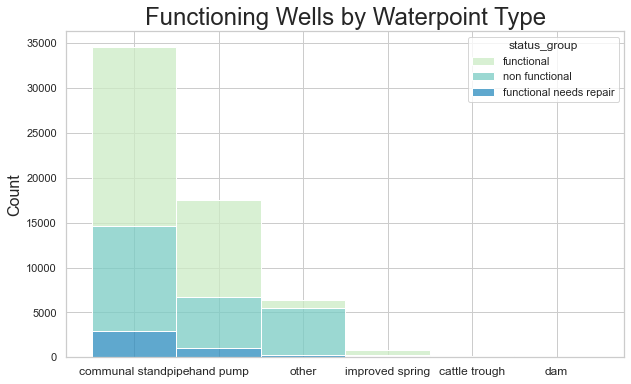

In [ ]:
sns.set_theme()

sns.set(rc={"figure.figsize":(10, 6)})
sns.set_style('whitegrid')

sns.histplot(data = df, x = 'waterpoint_type_group', hue = 'status_group',
             bins = 10, binwidth = 6, palette = 'GnBu', legend = 'full', 
             multiple = 'stack')


plt.title("Functioning Wells by Waterpoint Type",fontsize= 24)
plt.xlabel(None)
plt.ylabel("Count", fontsize = 16)
plt.xticks(rotation = 0, fontsize = 12);

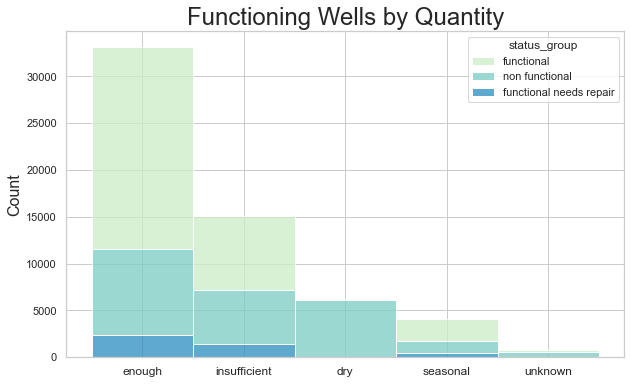

In [ ]:
sns.set_theme()

sns.set(rc={"figure.figsize":(10, 6)})
sns.set_style('whitegrid')

sns.histplot(data = df, x = 'quantity', hue = 'status_group',
             bins = 10, binwidth = 6, palette = 'GnBu', legend = 'full', 
             multiple = 'stack')


plt.title("Functioning Wells by Quantity",fontsize= 24)
plt.xlabel(None)
plt.ylabel("Count", fontsize = 16)
plt.xticks(rotation = 0, fontsize = 12);

In [ ]:
# Save the decision tree model as a pickle in a file
joblib.dump(dtc_pipe, 'dtc_pipe.pkl')

['dtc_pipe.pkl']

#### Results 

The decision tree model's accuracy was less than the logistic regression model and did not improve upon the logistic regression accuracy, though the f1-score for non-functional wells of both models remained the same. 

#### Use gridsearch for hyperparameter tuning.

In [ ]:
params = {}
params['dtc__criterion'] = ['gini', 'entropy']
params['dtc__min_samples_leaf'] = [1, 3, 5, 7, 10]
params['dtc__max_depth'] = [1,3,5,7,9]
params['dtc__splitter'] = ['best', 'random']

gs = GridSearchCV(estimator=dtc_pipe,
                 param_grid=params,
                 cv=3)

In [ ]:
gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [0, 2,
                                                                          4, 5,
                                                                          12]),
                                                                        ('subpipe_cat',
                 

In [ ]:
# Identify the best parameters
gs.best_params_

{'dtc__criterion': 'gini',
 'dtc__max_depth': 9,
 'dtc__min_samples_leaf': 5,
 'dtc__splitter': 'best'}

In [ ]:
# Examine cross validation results
gs.cv_results_['mean_test_score']

array([0.6424018 , 0.6424018 , 0.6424018 , 0.6424018 , 0.6424018 ,
       0.6424018 , 0.6424018 , 0.6424018 , 0.6424018 , 0.6424018 ,
       0.69427609, 0.69441077, 0.69427609, 0.69441077, 0.69429854,
       0.69443322, 0.69427609, 0.69445567, 0.69450056, 0.69461279,
       0.71270483, 0.70826038, 0.71261504, 0.70810325, 0.71265993,
       0.70808081, 0.71272727, 0.7081257 , 0.71261504, 0.70808081,
       0.72489338, 0.72282828, 0.72480359, 0.72255892, 0.72455668,
       0.72253648, 0.72453423, 0.72210999, 0.72430976, 0.72190797,
       0.73719416, 0.73476992, 0.73705948, 0.73429854, 0.73748597,
       0.73297419, 0.73643098, 0.73313131, 0.73542088, 0.73236813,
       0.6424018 , 0.6424018 , 0.6424018 , 0.6424018 , 0.6424018 ,
       0.6424018 , 0.6424018 , 0.6424018 , 0.6424018 , 0.6424018 ,
       0.69342312, 0.6935578 , 0.69342312, 0.6935578 , 0.69342312,
       0.6935578 , 0.69342312, 0.69360269, 0.69351291, 0.69362514,
       0.7006734 , 0.69723906, 0.70060606, 0.6973064 , 0.70056

#### Evaluate decision tree gridsearch results

In [ ]:
y_hat = gs.predict(X_test)

In [ ]:
print(classification_report(y_test, y_hat))

                         precision    recall  f1-score   support

             functional       0.70      0.93      0.80      8098
functional needs repair       0.58      0.15      0.23      1074
         non functional       0.85      0.57      0.68      5678

               accuracy                           0.74     14850
              macro avg       0.71      0.55      0.57     14850
           weighted avg       0.75      0.74      0.72     14850



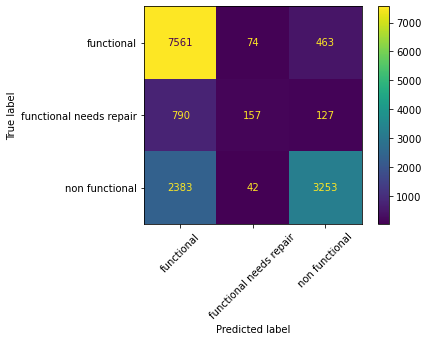

In [ ]:
plot_confusion_matrix(gs, X_test, y_test, xticks_rotation = 45);

In [ ]:
# Save the model as a pickle in a file
joblib.dump(gs, 'grid_search_dtc.pkl')

['grid_search_dtc.pkl']

#### Results

While accuracy decreased overall, the precision score on non-functional wells improved from 77% to 85%. This could be a good model if we only focus on precision score for non-functioning wells. Wells that need repair precision score also improved by 20%, this opens a path to possibly identify wells that could soon be non-functioning. 

### 4.  Random Forest with SMOTE and Tuning

Use a random forest model to further explore whether the precision or recall score on non-functioning wells can be improved. Address class imbalance issues with SMOTE. Further tune the model using search tools for best hyperparameters. 

In [ ]:
# Instantiate a Random Forest Classifier

rfc = RandomForestClassifier(random_state=42)

# Instantiate SMOTE for class imbalance

sm = SMOTE(sampling_strategy = 'auto', random_state = 42)

# Create pipeline

rfc_model_pipe = ImPipeline(steps=[('ct_loo', CT_loo),
                             ('sm', sm),
                            ('rfc', rfc)])


In [ ]:
rfc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct_loo',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 2, 4, 5, 12]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ce_loo',
           

In [ ]:
rfc_model_pipe.score(X_train, y_train)

0.9984960718294051

#### Evaluate results on Random Forest

In [ ]:
y_hat_rfc = rfc_model_pipe.predict(X_test)

In [ ]:
print(classification_report(y_test, y_hat_rfc))

                         precision    recall  f1-score   support

             functional       0.82      0.85      0.83      8098
functional needs repair       0.44      0.43      0.44      1074
         non functional       0.82      0.78      0.80      5678

               accuracy                           0.79     14850
              macro avg       0.69      0.69      0.69     14850
           weighted avg       0.79      0.79      0.79     14850



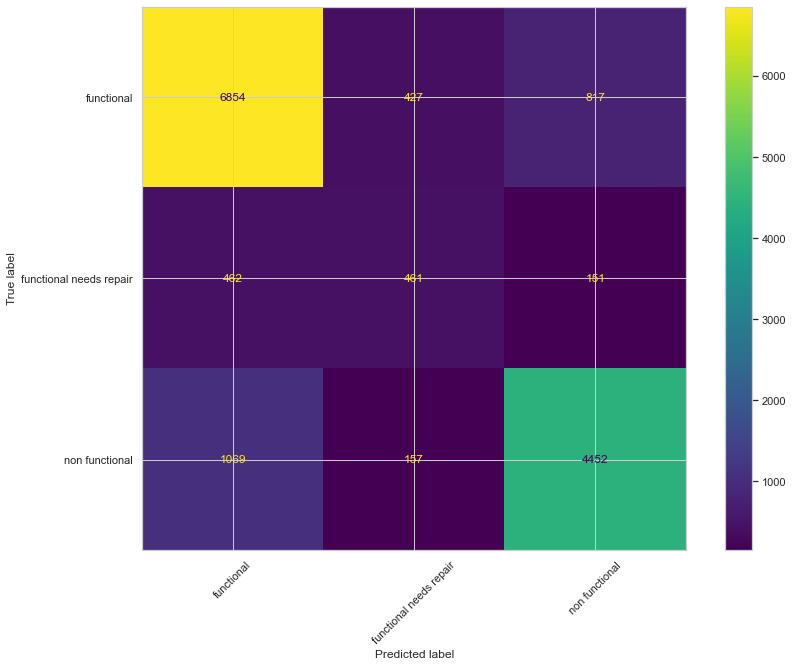

In [ ]:
plot_confusion_matrix(rfc_model_pipe, X_test, y_test, xticks_rotation = 45);

In [ ]:
# Save the random forest model as a pickle in a file
joblib.dump(rfc_model_pipe, 'rfc_model.pkl')

['rfc_model.pkl']

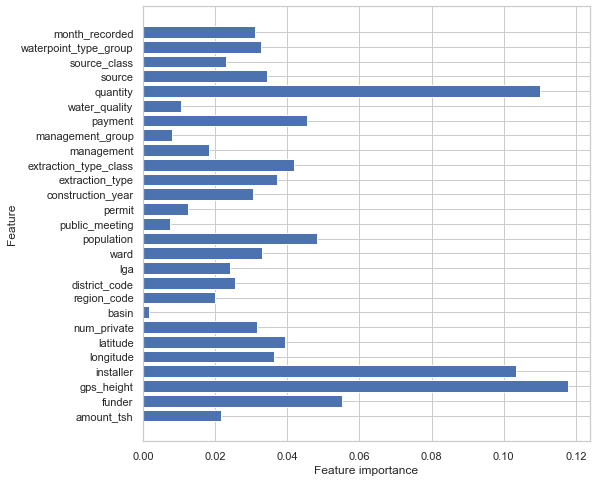

In [ ]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(rfc_model_pipe.named_steps['rfc'])



In [ ]:
important_features_dict = {}
for idx, val in enumerate(final_model.named_steps['rfc'].feature_importances_):
    important_features_dict[idx] = val

important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print(f'5 most important features: {important_features_list[:10]}')

5 most important features: [22, 2, 3, 1, 17, 12, 20, 23, 16, 5]


<AxesSubplot:>

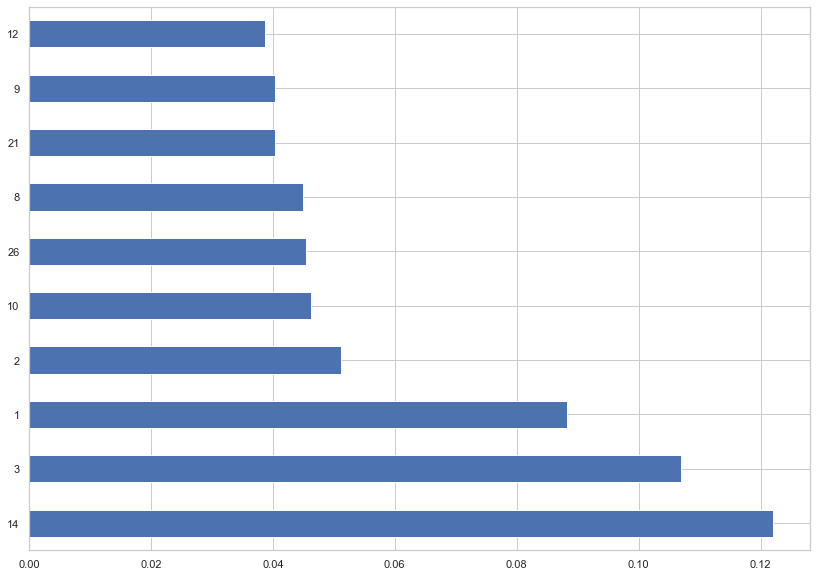

In [ ]:
feat_importances = pd.Series(final_model.named_steps['rfc'].feature_importances_, index= important_features_list)
feat_importances.nlargest(10).plot(kind='barh')

#### Gridsearch for hyperparameter tuning

In [ ]:
# Grid Search for better model criteria 

params = {'rfc__n_estimators': [10],
          'rfc__criterion': ['gini'],
          'rfc__min_samples_leaf': [1, 5, 10],
          'rfc__max_depth': [1, 5, 9],
          'rfc__max_features': [9]
          }

gs_rfc = GridSearchCV(estimator=rfc_model_pipe,
                 param_grid=params, n_jobs = -1,
                 cv=3)

In [ ]:
gs_rfc.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [0, 2,
                                                                          4, 5,
                                                                          12]),
                                                                        ('subpipe_cat',
                 

In [ ]:
# Best parameters for further tuning
gs_rfc.best_params_

{'rfc__criterion': 'gini',
 'rfc__max_depth': 9,
 'rfc__max_features': 9,
 'rfc__min_samples_leaf': 5,
 'rfc__n_estimators': 10}

In [ ]:
gs_rfc.score(X_train, y_train)

0.5083726150392817

#### Evaluate gridsearch results

In [ ]:
y_hat_gs_rfc = gs_rfc.predict(X_test)

In [ ]:
print(classification_report(y_test, y_hat_gs_rfc))

                         precision    recall  f1-score   support

             functional       0.70      0.50      0.58      8098
functional needs repair       0.13      0.56      0.21      1074
         non functional       0.62      0.48      0.54      5678

               accuracy                           0.50     14850
              macro avg       0.48      0.51      0.44     14850
           weighted avg       0.63      0.50      0.54     14850



In [ ]:
# Save the rfc gridsearch model model as a pickle in a file
joblib.dump(gs_rfc, 'gs_rfc.pkl')

['gs_rfc.pkl']

#### Results summary on Random Forest Gridsearch

Accuracy decreased significantly, perhaps as a result of using 10 n_estimators rather than the default 100 to cut down on processing time. This model though suggests where to explore for max_depth, and samples leaf and split. 

#### Use Randomized Search 

In [ ]:

from sklearn.model_selection import RandomizedSearchCV

# Based in previous gridsearch, optimize for max depth, min samples leaf and split

random_grid = {
         'rfc__bootstrap': [True],
         'rfc__max_depth': [10, 20, 50, 100],
         'rfc__max_features': ['auto', 'sqrt'],
         'rfc__min_samples_leaf': [1, 2, 4],
         'rfc__min_samples_split': [2, 5, 10],
         'rfc__n_estimators': [10, 100]
}

random = RandomizedSearchCV(estimator = rfc_model_pipe,
                 param_distributions = random_grid, n_jobs = -1,
                 verbose = 2, random_state = 42, cv=3)

In [ ]:
random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 124.2min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ct',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('subpipe_num',
                                                                               Pipeline(steps=[('num_impute',
                                                                                                SimpleImputer()),
                                                                                               ('ss',
                                                                                                StandardScaler())]),
                                                                               [0,
                                                                                2,
                                                                                4,
                                                

In [ ]:
# Best paramters from randomized search on RFC
random.best_params_

{'rfc__n_estimators': 100,
 'rfc__min_samples_split': 5,
 'rfc__min_samples_leaf': 2,
 'rfc__max_features': 'auto',
 'rfc__max_depth': 100,
 'rfc__bootstrap': True}

#### Evaluate randomized search best parameter results

In [ ]:
random.score(X_train, y_train)

0.8312457912457912

In [ ]:
y_hat_random = random.predict(X_test)

In [ ]:
print(classification_report(y_test, y_hat_random))

                         precision    recall  f1-score   support

             functional       0.82      0.79      0.80      8098
functional needs repair       0.33      0.60      0.43      1074
         non functional       0.82      0.74      0.78      5678

               accuracy                           0.76     14850
              macro avg       0.66      0.71      0.67     14850
           weighted avg       0.79      0.76      0.77     14850



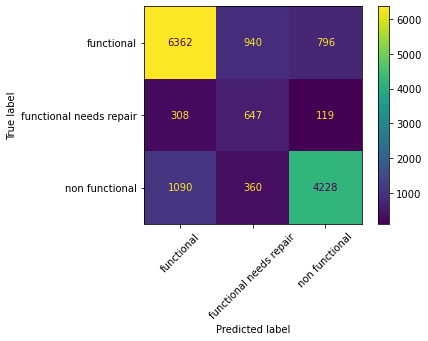

In [ ]:
plot_confusion_matrix(random, X_test, y_test, xticks_rotation = 45);

In [ ]:
# Save the model as a pickle in a file
joblib.dump(random, 'random_rfc.pkl')

['random_rfc.pkl']

#### Gridsearch based on randomized results

In [ ]:
# Based on randomized search conduct one more gridsearch
params = {
          'rfc__n_estimators': [100],
          'rfc__min_samples_leaf': [2,3],
          'rfc__max_depth': [100, 150],
          'rfc__min_samples_split': [3, 5, 7],
          'rfc__max_features': ['auto']
}

gs_rfc_2 = GridSearchCV(estimator=rfc_model_pipe,
                 param_grid=params, n_jobs = -1,  
                 verbose = 2, cv = 3)
                 

In [ ]:
gs_rfc_2.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 129.6min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [0, 2,
                                                                          4, 5,
                                                                          12]),
                                                                        ('subpipe_cat',
                 

In [ ]:
# Score the model on training data
gs_rfc_2.score(X_train, y_train)

0.8340291806958474

In [ ]:
# examine best paramters
gs_rfc_2.best_params_

{'rfc__max_depth': 100,
 'rfc__max_features': 'auto',
 'rfc__min_samples_leaf': 2,
 'rfc__min_samples_split': 3,
 'rfc__n_estimators': 100}

In [ ]:
# create predicted target using test set
y_hat_rfc_2 = gs_rfc_2.predict(X_test)

In [ ]:
print(classification_report(y_test, y_hat_rfc_2))

                         precision    recall  f1-score   support

             functional       0.82      0.79      0.81      8098
functional needs repair       0.34      0.60      0.43      1074
         non functional       0.83      0.75      0.79      5678

               accuracy                           0.76     14850
              macro avg       0.66      0.71      0.67     14850
           weighted avg       0.79      0.76      0.77     14850



In [ ]:
# select as final model
final_rfc_model = gs_rfc_2

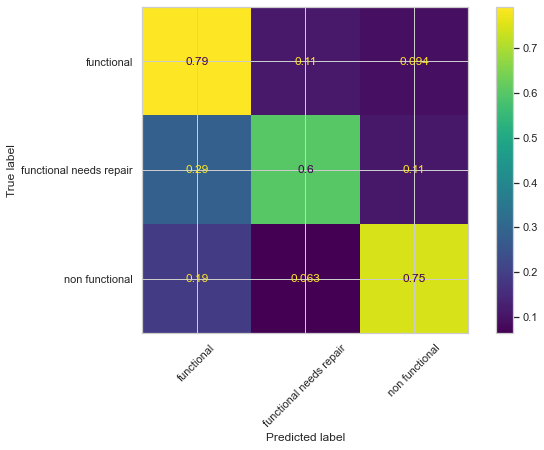

In [ ]:
# Plot confusion matrix with percentages
plot_confusion_matrix(final_rfc_model, 
                      X_test, y_test, 
                      xticks_rotation = 45, 
                      normalize = 'true'
                     );

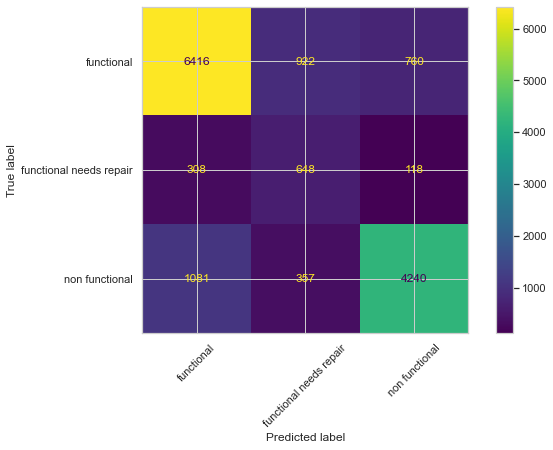

In [ ]:
# Plot matrix with case numbers
plot_confusion_matrix(final_rfc_model, 
                      X_test, y_test, 
                      xticks_rotation = 45, 
                      
                     );

plt.savefig('final RFC model matrix')

In [ ]:
# Save the model as a pickle in a file
joblib.dump(final_rfc_model, 'final_rfc_model.pkl')

['final_rfc_model.pkl']

In [ ]:
# Instantiate a Random Forest Classifier with final hyperparameters

rfc = RandomForestClassifier(max_depth = 100, max_features = 'auto', 
                             min_samples_leaf = 2, min_samples_split = 2, 
                             random_state=42)

# Instantiate SMOTE for class imbalance

sm = SMOTE(sampling_strategy = 'auto', random_state = 42)

# Create pipeline

final_model = ImPipeline(steps=[('ct_loo', CT_loo),
                             ('sm', sm),
                            ('rfc', rfc)])


In [ ]:
final_model.fit(X_train, y_train)

Pipeline(steps=[('ct_loo',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 2, 4, 5, 12]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ce_loo',
           

In [ ]:
y_hat_final = final_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_hat_final))

                         precision    recall  f1-score   support

             functional       0.82      0.85      0.84      8098
functional needs repair       0.44      0.46      0.45      1074
         non functional       0.83      0.78      0.81      5678

               accuracy                           0.80     14850
              macro avg       0.70      0.70      0.70     14850
           weighted avg       0.80      0.80      0.80     14850



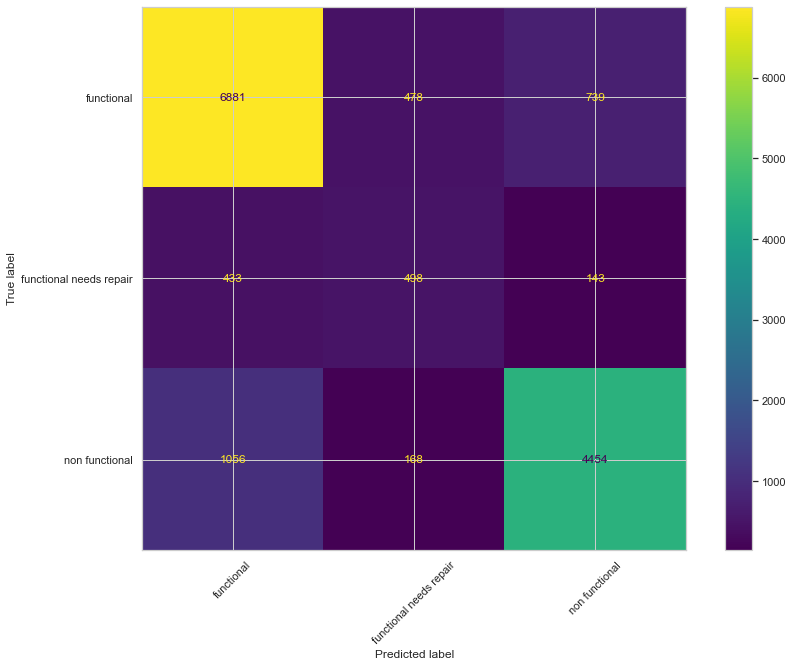

In [ ]:
plot_confusion_matrix(final_model, X_test, y_test, 
                      xticks_rotation = 45)

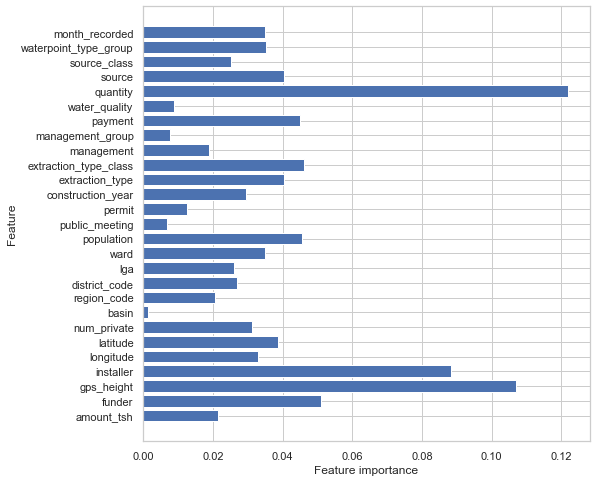

In [ ]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(final_model.named_steps['rfc'])

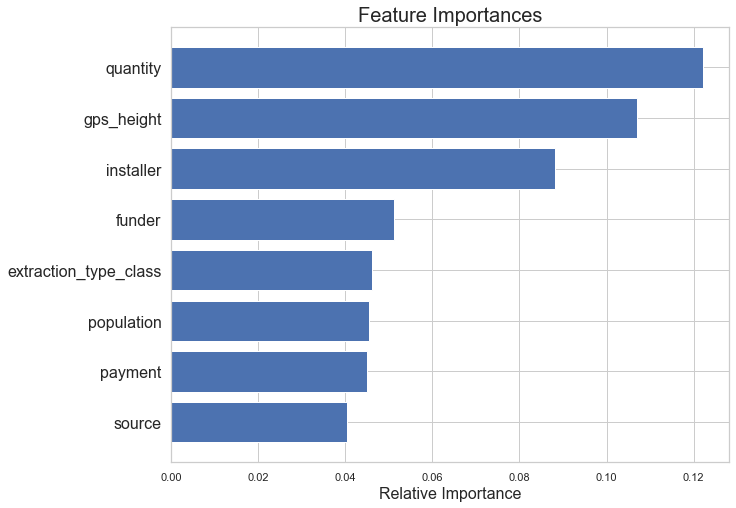

In [ ]:
# sort the top 8 features

features = X_train.columns
importances = final_model.named_steps['rfc'].feature_importances_
indices = np.argsort(importances)

# customized number 
num_features = 8

plt.figure(figsize=(10, 8))
plt.title('Feature Importances', fontsize = 20)

# only plot the customized number of features
plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]], fontsize = 16)
plt.xlabel('Relative Importance', fontsize = 16)

plt.savefig('Feature Importance.png')
plt.show();

### 5. Gradient Boost Model

Compare a default parameter gradient boost model against the RFC final model and select final model. 

In [ ]:
# Gradient Boost model 
gbc_model_pipe = Pipeline([('ct_loo', CT_loo), ('gbc', GradientBoostingClassifier(random_state=42))])

gbc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct_loo',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 2, 4, 5, 12]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ce_loo',
           

In [ ]:
gbc_model_pipe.score(X_train, y_train)

0.7560044893378227

In [ ]:
y_hat_gbc = gbc_model_pipe.predict(X_test)

print(classification_report(y_test, y_hat_gbc))

                         precision    recall  f1-score   support

             functional       0.72      0.92      0.81      8098
functional needs repair       0.58      0.12      0.20      1074
         non functional       0.82      0.62      0.71      5678

               accuracy                           0.75     14850
              macro avg       0.71      0.55      0.57     14850
           weighted avg       0.75      0.75      0.72     14850



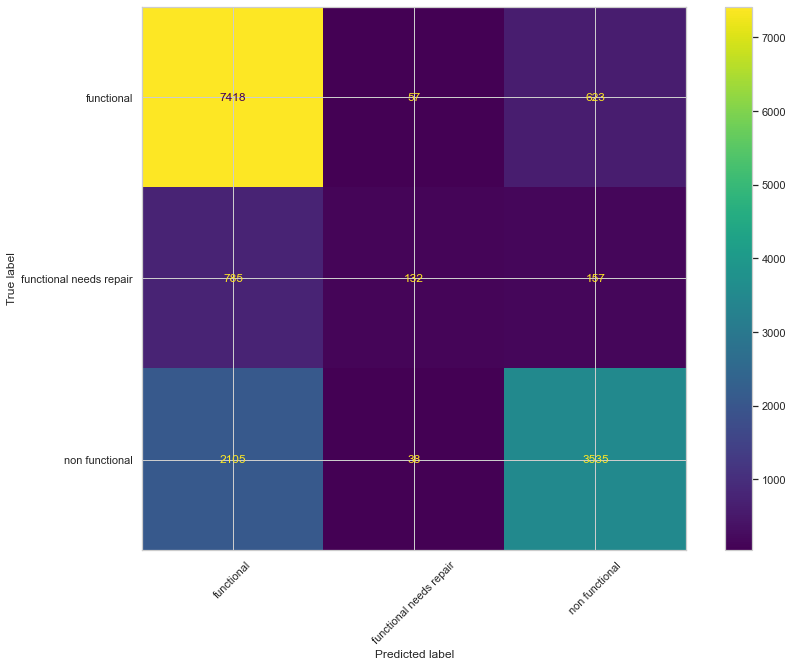

In [ ]:
plot_confusion_matrix(gbc_model_pipe, X_test, y_test, xticks_rotation = 45);

#### Feature Importance exploration

In [ ]:
# Funder explore
df.funder.value_counts()

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Mungaya                      1
Fpct Mulala                  1
Boma Saving                  1
Care Int                     1
D Ct                         1
Name: funder, Length: 1897, dtype: int64

In [ ]:
# Plot four shared cross country water basins in the region
# Plot visual showing basins and functional wells
df_funder = df[df['funder'].isin(['Government Of Tanzania', 'Danida', 'Hesawa', 
                                'Rwssp', 'World Bank'
                                ])]


In [ ]:
df_funder.status_group.value_counts(normalize = True)

non functional             0.473398
functional                 0.450797
functional needs repair    0.075804
Name: status_group, dtype: float64

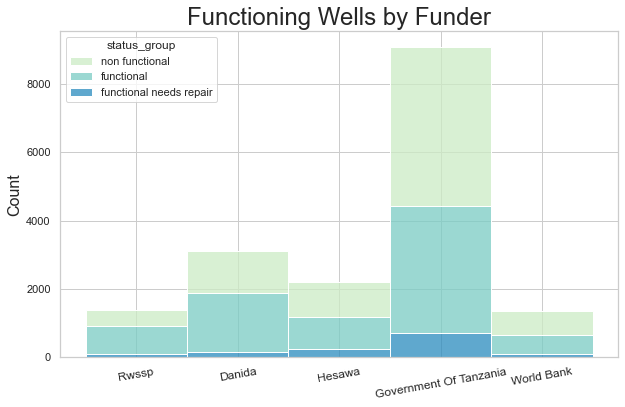

In [ ]:

sns.set_theme()

sns.set(rc={"figure.figsize":(10, 6)})
sns.set_style('whitegrid')

sns.histplot(data = df_funder, x = 'funder', hue = 'status_group',
             bins = 10, binwidth = 6, palette = 'GnBu', legend = 'full', 
             multiple = 'stack')


plt.title("Functioning Wells by Funder",fontsize= 24)
plt.xlabel(None)
plt.ylabel("Count", fontsize = 16)
plt.xticks(rotation = 10, fontsize = 12)

plt.savefig('functioning wells by funder.png')

plt.show();


In [ ]:
# Explore Installer
df.installer.value_counts()

DWE                     17402
Government               1825
RWE                      1206
Commu                    1060
DANIDA                   1050
                        ...  
villager                    1
GACHUMA CONSTRUCTION        1
Atlas                       1
TWESA/JAMII                 1
NDM                         1
Name: installer, Length: 2145, dtype: int64

In [ ]:
df_installer = df[df['installer'].isin(['Government', 'DANIDA', 'RWE', 
                                'Commu', 'DWE'
                                ])]

In [ ]:
df_installer.status_group.value_counts(normalize = True)

functional                 0.511822
non functional             0.393692
functional needs repair    0.094486
Name: status_group, dtype: float64

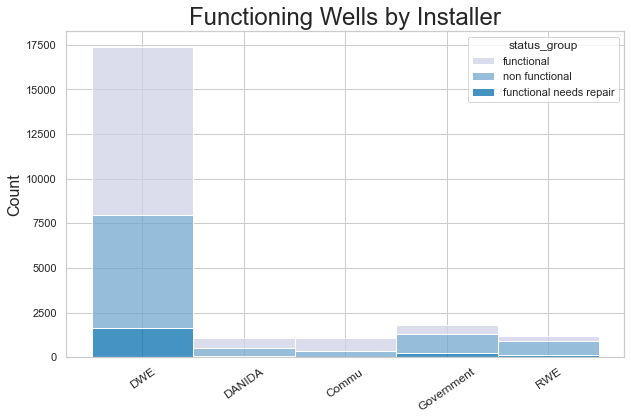

In [ ]:
sns.histplot(data = df_installer, x = 'installer', hue = 'status_group',
             bins = 10, binwidth = 6, palette = 'PuBu', legend = 'full', 
             multiple = 'stack')


plt.title("Functioning Wells by Installer",fontsize= 24)
plt.xlabel(None)
plt.ylabel("Count", fontsize = 16)
plt.xticks(rotation = 35, fontsize = 12)

plt.savefig('functioning wells by installer.png')

plt.show();


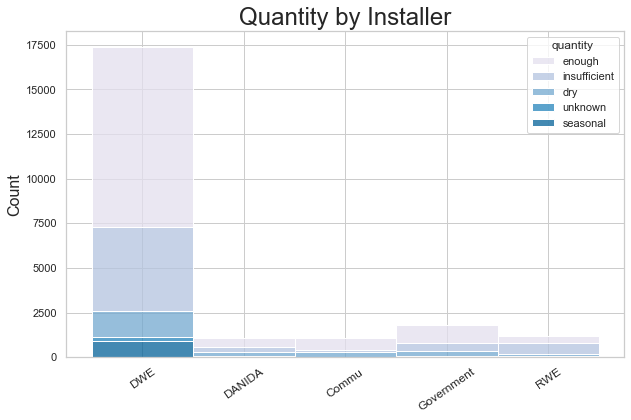

In [ ]:
sns.histplot(data = df_installer, x = 'installer', hue = 'quantity',
             bins = 10, binwidth = 6, palette = 'PuBu', legend = 'full', 
             multiple = 'stack')


plt.title("Quantity by Installer",fontsize= 24)
plt.xlabel(None)
plt.ylabel("Count", fontsize = 16)
plt.xticks(rotation = 35, fontsize = 12)

#plt.savefig('')

plt.show();


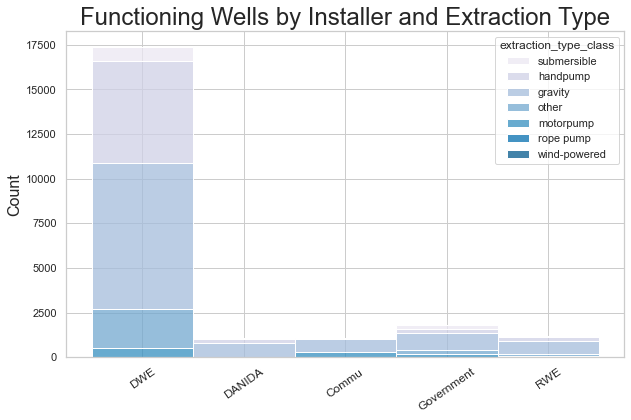

In [ ]:
sns.histplot(data = df_installer, x = 'installer', hue = 'extraction_type_class',
             bins = 10, binwidth = 6, palette = 'PuBu', legend = 'full', 
             multiple = 'stack')


plt.title("Functioning Wells by Installer and Extraction Type",fontsize= 24)
plt.xlabel(None)
plt.ylabel("Count", fontsize = 16)
plt.xticks(rotation = 35, fontsize = 12)

#plt.savefig('')

plt.show();
#



In [ ]:
# Sea Level wells
df.gps_height.value_counts(bins = 1000, normalize = True)

(-1.34, 1.52]         0.345017
(-15.64, -12.78]      0.002795
(-18.5, -15.64]       0.002492
(-21.36, -18.5]       0.002340
(1288.52, 1291.38]    0.002104
                        ...   
(2529.76, 2532.62]    0.000000
(2526.9, 2529.76]     0.000000
(2524.04, 2526.9]     0.000000
(2515.46, 2518.32]    0.000000
(2572.66, 2575.52]    0.000000
Name: gps_height, Length: 1000, dtype: float64

In [ ]:
# Consider worldbank, top installers, and extraction type
df_worldbank = df[df['funder'].isin(['World Bank'])]

df_worldbank.status_group.value_counts(normalize = True)


non functional             0.524092
functional                 0.404003
functional needs repair    0.071905
Name: status_group, dtype: float64

In [ ]:
df_worldbank.installer.value_counts()

DWE                           152
World                         120
World Bank                     95
Government                     57
WORLD BANK                     46
                             ... 
SAXON BUILDING CONTRACTORS      1
EFAM                            1
JUINE CO                        1
Wadeco                          1
Word bank                       1
Name: installer, Length: 131, dtype: int64

In [ ]:
#Clean installer column for world bank
#df.loc[df["gender"] == "male", "gender"] = 1

df_worldbank.loc[df_worldbank['installer'] == 'World', 'installer'] = 'World Bank'
df_worldbank.loc[df_worldbank['installer'] == 'WORLD BANK', 'installer'] = 'World Bank'
df_worldbank.loc[df_worldbank['installer'] == 'Word Bank', 'installer'] = 'World Bank'
df_worldbank.loc[df_worldbank['installer'] == 'Word bank', 'installer'] = 'World Bank'
df_worldbank.loc[df_worldbank['installer'] == 'world bank', 'installer'] = 'World Bank'
df_worldbank.loc[df_worldbank['installer'] == 'Word', 'installer'] = 'World Bank'
df_worldbank.loc[df_worldbank['installer'] == 'world', 'installer'] = 'World Bank'

In [ ]:
df_worldbank.installer.value_counts(normalize = True)

World Bank                        0.201046
DWE                               0.113602
Government                        0.042601
Water board                       0.023916
Gwasco L                          0.020927
                                    ...   
Conta                             0.000747
Building works engineering Ltd    0.000747
GEN                               0.000747
Consultant Engineer               0.000747
EFAM                              0.000747
Name: installer, Length: 125, dtype: float64

In [ ]:
df_worldbank.extraction_type_class.value_counts(normalize = True)

submersible    0.336546
gravity        0.326909
other          0.135656
handpump       0.106004
motorpump      0.094885
Name: extraction_type_class, dtype: float64

In [ ]:
df_worldbank.source.value_counts(normalize = True)

machine dbh             0.581913
spring                  0.120830
river                   0.118606
shallow well            0.092661
rainwater harvesting    0.038547
lake                    0.023721
dam                     0.020756
hand dtw                0.002224
other                   0.000741
Name: source, dtype: float64

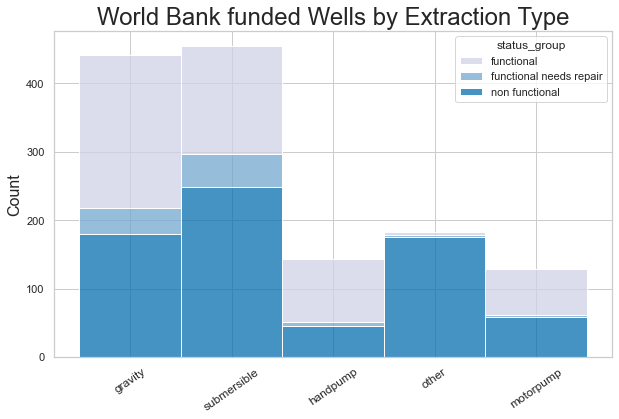

In [ ]:
sns.histplot(data = df_worldbank, x = 'extraction_type_class', hue = 'status_group',
             bins = 10, binwidth = 6, palette = 'PuBu', legend = 'full', 
             multiple = 'stack')


plt.title("World Bank funded Wells by Extraction Type",fontsize= 24)
plt.xlabel(None)
plt.ylabel("Count", fontsize = 16)
plt.xticks(rotation = 35, fontsize = 12)

#plt.savefig('')

plt.show();
#

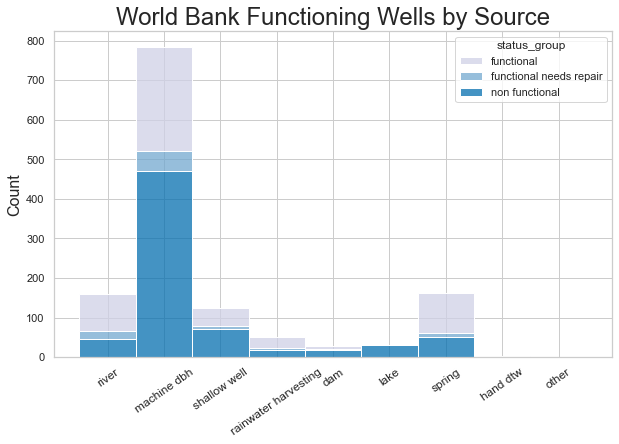

In [ ]:
sns.histplot(data = df_worldbank, x = 'source', hue = 'status_group',
             bins = 10, binwidth = 6, palette = 'PuBu', legend = 'full', 
             multiple = 'stack')


plt.title("World Bank Functioning Wells by Source",fontsize= 24)
plt.xlabel(None)
plt.ylabel("Count", fontsize = 16)
plt.xticks(rotation = 35, fontsize = 12)

#plt.savefig('')

plt.show();
#

In [ ]:
df_worldbank.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [ ]:
#examine quantity,extraction_type_class, waterpoint_type
df_worldbank.quantity.value_counts()

enough          780
insufficient    239
dry             142
unknown         122
seasonal         66
Name: quantity, dtype: int64

In [ ]:
#Examine quantity enough and functioning wells
df_worldbank_enough = df_worldbank[df_worldbank['quantity'].isin(['enough'])]

df_worldbank_enough.status_group.value_counts(normalize = True)

functional                 0.511538
non functional             0.411538
functional needs repair    0.076923
Name: status_group, dtype: float64

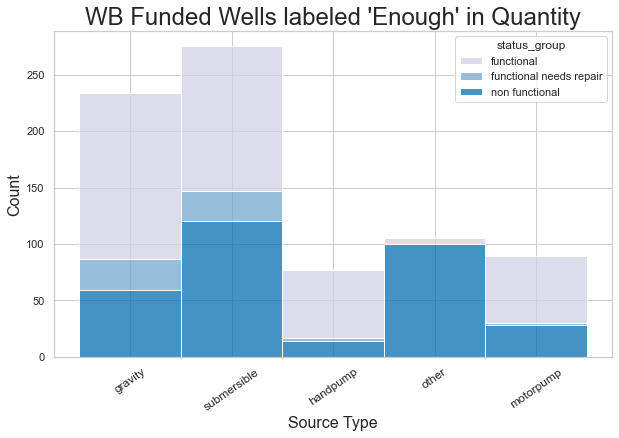

In [ ]:
sns.histplot(data = df_worldbank_enough, x = 'extraction_type_class', hue = 'status_group',
             bins = 10, binwidth = 6, palette = 'PuBu', legend = 'full', 
             multiple = 'stack')


plt.title("WB Funded Wells labeled 'Enough' in Quantity",fontsize= 24)
plt.xlabel("Source Type", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.xticks(rotation = 35, fontsize = 12)

plt.savefig('World Bank Enough.png')

plt.show();
#

In [ ]:
df_worldbank_enough.extraction_type_class.value_counts(normalize = False)

submersible    275
gravity        234
other          105
motorpump       89
handpump        77
Name: extraction_type_class, dtype: int64

### 6. Data Visualizations

Create three data visualizations to communicate findings to Water Aid.

In [ ]:
# Examine full dataframe columns
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

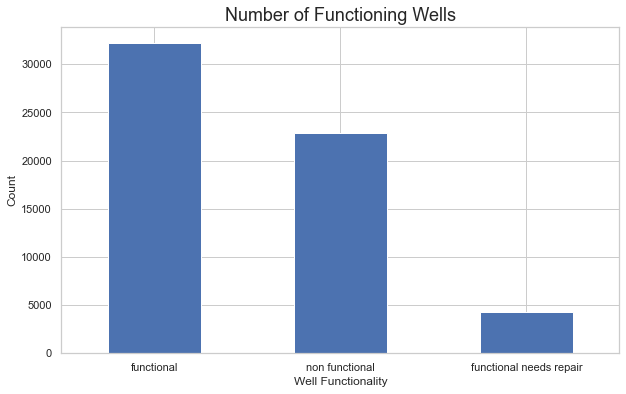

In [ ]:
# Visualize well status count from dataset

df.status_group.value_counts().plot(kind="bar")
plt.title("Number of Functioning Wells",fontsize= 18)
plt.xlabel("Well Functionality", fontsize = 12)
plt.xticks(rotation=0)
plt.ylabel("Count", fontsize = 12)

plt.savefig('Number of Functioning Wells.png')

plt.show();



In [ ]:
# Plot four shared cross country water basins in the region
# Plot visual showing basins and functional wells
df_basin = df[df['basin'].isin(['Lake Nyasa', 'Lake Victoria', 'Lake Tanganyika', 
                                'Ruvuma / Southern Coast',
                                ])]

In [ ]:
df_basin.basin.value_counts()

Lake Victoria              10248
Lake Tanganyika             6432
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Name: basin, dtype: int64

In [ ]:
df_basin.status_group.value_counts()

functional                 13201
non functional             10750
functional needs repair     2307
Name: status_group, dtype: int64

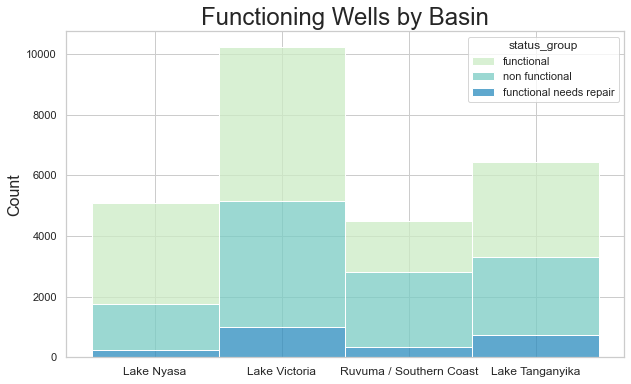

In [ ]:
# Use Seaborn to and stacked histogram to show the four basins and well status

sns.set_theme()

sns.set(rc={"figure.figsize":(10, 6)})
sns.set_style('whitegrid')

sns.histplot(data = df_basin, x = 'basin', hue = 'status_group',
             bins = 10, binwidth = 6, palette = 'GnBu', legend = 'full', 
             multiple = 'stack')


plt.title("Functioning Wells by Basin",fontsize= 24)
plt.xlabel(None)
plt.ylabel("Count", fontsize = 16)
plt.xticks(rotation = 0, fontsize = 12)

plt.savefig('functioning wells by basin.png')

plt.show();



In [ ]:
# Examine well status for two basin recommendations: Lake Victoria and Ruvuma
df_victoria = df[df['basin'].isin(['Lake Victoria'])]

df_victoria.status_group.value_counts()

functional                 5100
non functional             4159
functional needs repair     989
Name: status_group, dtype: int64

In [ ]:
# Create dataframe for Ruvuma Basin
df_ruvuma = df[df['basin'].isin(['Ruvuma / Southern Coast'])]

#Examine well function status for Ruvuma Basin
print(df_ruvuma.status_group.value_counts(normalize = True))
print()
print(df_ruvuma.status_group.value_counts())

non functional             0.555753
functional                 0.371689
functional needs repair    0.072557
Name: status_group, dtype: float64

non functional             2497
functional                 1670
functional needs repair     326
Name: status_group, dtype: int64


In [ ]:
df_ruvuma.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
26,55012,500.0,2013-01-16,Sobodo,200,Kilolo Star,39.370777,-9.942532,Ruhoma Primary School,0,...,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
46,45111,20.0,2013-02-05,Lga,240,LGA,39.087415,-11.000604,Mikoroshini,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional needs repair
91,62591,0.0,2013-01-20,Jica,212,Kokeni,38.962945,-10.476566,Maringini,0,...,salty,salty,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,non functional
98,33379,0.0,2013-02-19,Danida,1000,DWE,35.542173,-10.808853,Kwa Mathiasi,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional needs repair


In [ ]:
#examine descriptive statistics for Ruvuma
df_ruvuma.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000
mean,37322.257067,228.390385,410.640329,38.316789,-10.485215,0.124861,52.386156,17.969508,274.193635,1899.780993
std,21489.456338,777.985990,338.566284,1.549237,0.591604,6.745120,38.834945,19.720254,445.829301,425.083164
min,19.000000,0.000000,-90.000000,34.889771,-11.649440,0.000000,8.000000,1.000000,0.000000,0.000000
25%,18908.000000,0.000000,164.000000,37.244214,-10.850966,0.000000,10.000000,2.000000,1.000000,1982.000000
50%,37228.000000,0.000000,342.000000,38.935668,-10.626269,0.000000,80.000000,5.000000,200.000000,1994.000000
75%,55874.000000,50.000000,585.000000,39.448147,-10.250908,0.000000,90.000000,33.000000,360.000000,2007.000000
max,74247.000000,15000.000000,1641.000000,40.345193,-8.496806,450.000000,99.000000,63.000000,8000.000000,2013.000000


In [ ]:
# Build dataframe ruvuma basin with construction year
df_ruvuma_built = df_ruvuma[df_ruvuma.construction_year != 0]

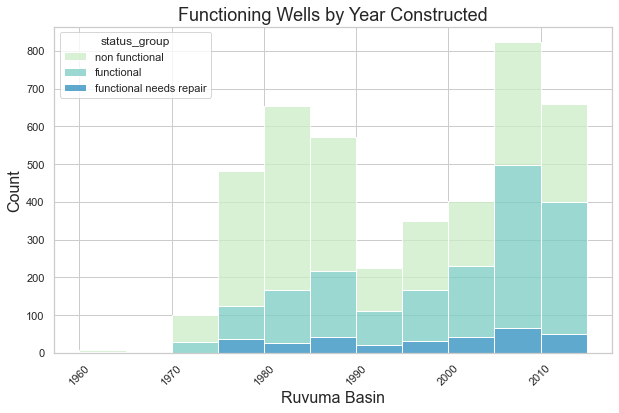

''

In [ ]:
# Create data visualization, histogram, for functioning wells in Ruvuma
sns.set_theme()

sns.set(rc={"figure.figsize":(10, 6)})
sns.set_style('whitegrid')

sns.histplot(data = df_ruvuma_built, x = 'construction_year', hue = 'status_group',
             bins = 20, binwidth = 5, palette = 'GnBu', legend = 'full', 
             multiple = 'stack')


plt.title("Functioning Wells by Year Constructed",fontsize= 18)
plt.xlabel('Ruvuma Basin', fontsize = 16)
plt.xticks(rotation=0)
plt.ylabel("Count", fontsize = 16)
plt.xticks(rotation = 45)

plt.savefig('functioning wells ruvuma.png')

plt.show()

;

In [ ]:
# Dataframe for older wells in Ruvuma, 1975 to 1990
df_ruvuma_old_wells = df_ruvuma.loc[(df_ruvuma.construction_year >= 1975) &
                                   (df_ruvuma.construction_year <= 1990)]

In [ ]:
# Percentage of wells in need of repair
df_ruvuma_old_wells.status_group.value_counts(normalize = True)

non functional             0.699024
functional                 0.236646
functional needs repair    0.064331
Name: status_group, dtype: float64

## Final Summary

The analysis conducted on the well data provided several insights into the functionality and status of wells across different regions and under various conditions. Key findings include:

1. **Model Performance**:
    - The Random Forest Classifier (RFC) model with tuned hyperparameters showed improved precision scores for non-functional wells, indicating its potential for identifying wells that may soon become non-functional.
    - The Gradient Boosting Classifier (GBC) model was also evaluated, but the RFC model was selected as the final model due to its better performance.

2. **Feature Importance**:
    - Feature importance analysis revealed the top features influencing the well status, which can guide future data collection and model improvements.

3. **Funder and Installer Analysis**:
    - Analysis of wells funded by different organizations (e.g., World Bank, Government of Tanzania) and installed by various entities highlighted the impact of these factors on well functionality.
    - Visualizations showed the distribution of well statuses by funder and installer, providing insights into which organizations and installers are associated with better well performance.

4. **Geographical Analysis**:
    - The functionality of wells was analyzed across different basins, with a focus on Lake Victoria and Ruvuma/Southern Coast basins.
    - The construction year of wells in the Ruvuma basin was examined, revealing trends in well functionality over time.



Overall, the analysis provides a comprehensive understanding of the factors influencing well functionality and 
offers actionable insights for improving water access in the region.

## Recommendations

Based on the analysis conducted, the following recommendations are proposed to improve well functionality and water access in the region:

1. **Focus on Key Features**:
    - Prioritize monitoring and maintenance of wells based on the top features identified in the feature importance analysis. This can help in early identification of wells that are likely to become non-functional.

2. **Targeted Interventions by Funders and Installers**:
    - Collaborate with funders and installers who have a track record of better well performance. For instance, wells funded by the World Bank and installed by certain entities showed better functionality. Strengthening partnerships with these organizations can lead to improved outcomes.

3. **Geographical Focus**:
    - Concentrate efforts on regions with higher rates of non-functional wells. The analysis highlighted specific basins, such as Lake Victoria and Ruvuma/Southern Coast, where targeted interventions could be beneficial.

4. **Historical Data Utilization**:
    - Utilize historical data on well construction years to identify trends and plan maintenance schedules. Older wells, particularly those constructed between 1975 and 1990 in the Ruvuma basin, may require more frequent inspections and repairs.

5. **Enhanced Data Collection**:
    - Improve data collection processes to capture more detailed information on well characteristics and conditions. This can enhance the accuracy of predictive models and support better decision-making.

6. **Continuous Model Tuning**:
    - Regularly update and tune predictive models to incorporate new data and improve their accuracy. This will help in maintaining the reliability of predictions and ensuring timely interventions.

7. **Community Engagement**:
    - Engage with local communities to gather insights and feedback on well functionality. Community involvement can provide valuable information and foster a sense of ownership, leading to better maintenance and sustainability of wells.

By implementing these recommendations, it is possible to enhance well functionality, ensure sustainable water access, and improve the overall effectiveness of water management initiatives in the region.